In [1]:
'''
Jupyter Notebook by Matthew Loukine
'''
'''
This first block of code is used for import statements, data loading and doing some data pre processing
Such as Motion Correction.
'''
# The following file is being used to test the Pipeline
''' Import statements for all the files involved'''
from main import *
from utils import *
from wfield_utils import *
from registration import *
from hemocorrection import *
from denoising import *
from debug_visualize import *
from data_loading_functions import *
from data_preprocessor import *

# Some extra imports we need
from tqdm import tqdm
import pickle
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta
import cv2
import os

# The folllowing code is from main(). 
# params are global variables used to modify the code
params = {
    'path_to_session_data':       r"C:\Users\evilm\Downloads\07-29-2024",
    'pipe_num':           0,              # select desired pipeline number
    'get_raw_brightness': False,
    'get_DeltaF':         False,
    'get_zScore':         False
          }
# This is inside def main()
# For purposes of testing to visualise the data we will do analysis here.
session_file_paths = get_file_paths(params['path_to_session_data'])
#print(session_file_paths)
# create an obj for each recording within the session
recording = rawDataPreprocessor(params['path_to_session_data'])
print(f'{datetime.datetime.now().time()}: Done loading session data into object')

# Currently 
print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
_, _, recording.all_frames = motion_correct(dat=recording.all_frames, out=None, mode='ecc', apply_shifts=True)
print(f'{datetime.datetime.now().time()}: Done Motion Correction')

# Loading all the other files.
blue_frames = recording.all_frames[:,0,...]
analog_data = load_dat_analog(recording.path_to_analog)
frame_times = load_mat_frameTimes(recording.path_to_frameTimes)
blue_ftimes = frame_times['frameTimes']

stim_matfile = r"C:\Users\evilm\Downloads\07-29-2024\data_mixed_full_grating_OdorStimulus_202407291652168_mat.mat"
stim_configs = pickle.loads(scipy.io.loadmat(stim_matfile)['configs'].tostring())
stim_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(stim_matfile)['experiment_start_timestamp'].tostring())
# Skipping software environement
stim_stim_frame_info = pickle.loads(scipy.io.loadmat(stim_matfile)['stimulus_frame_info'].tostring())
stim_user_data = pickle.loads(scipy.io.loadmat(stim_matfile)['user_data'].tostring())
stim_sync = scipy.io.loadmat(stim_matfile)['sync']

17:14:37.990557: Done loading session data into object
17:14:37.991556: Starting Motion Correction


Motion correction: 100%|██████████| 22/22 [02:51<00:00,  7.78s/it]

17:17:30.930649: Done Motion Correction



C:\Users\evilm\AppData\Local\Temp\ipykernel_63072\1311622015.py:59: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_configs = pickle.loads(scipy.io.loadmat(stim_matfile)['configs'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_63072\1311622015.py:60: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(stim_matfile)['experiment_start_timestamp'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_63072\1311622015.py:62: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_stim_frame_info = pickle.loads(scipy.io.loadmat(stim_matfile)['stimulus_frame_info'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_63072\1311622015.py:63: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_user_data = pickle.loads(scipy.io.loadmat(stim_matfile)['user_data'].tostring())


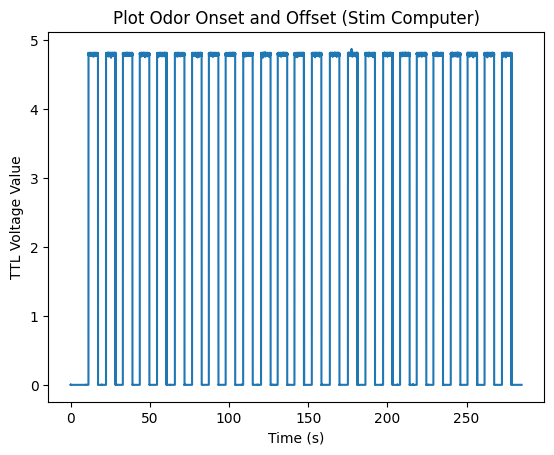

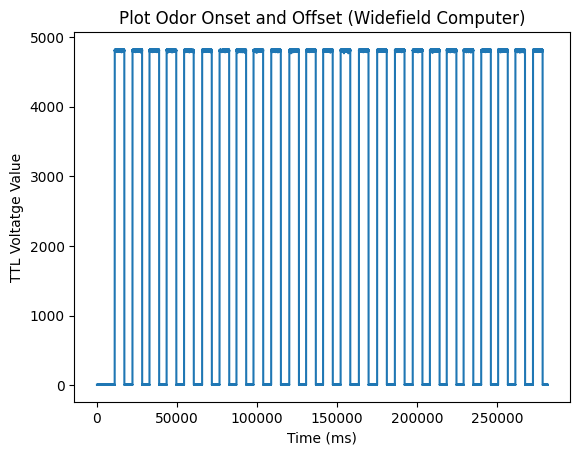

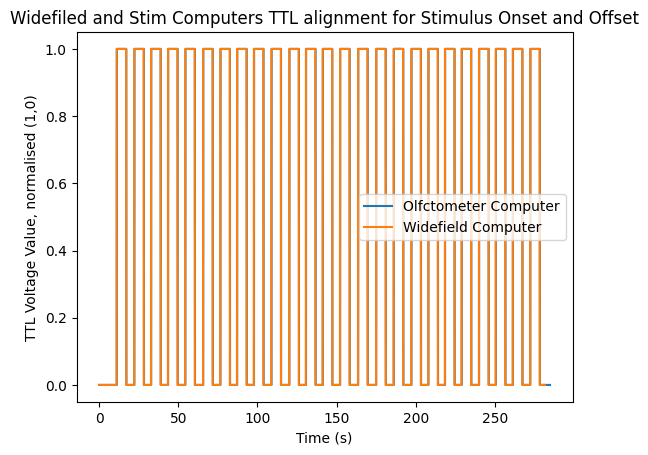

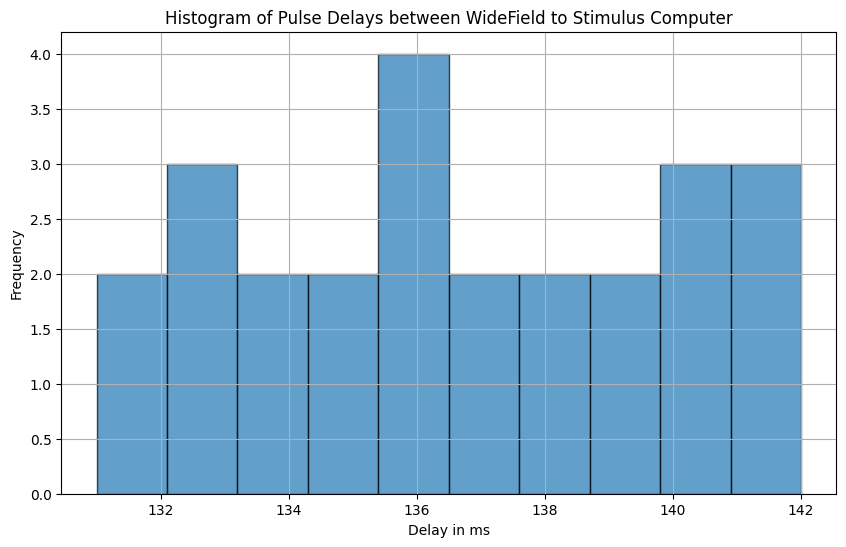

In [3]:
'''
This compares stimulus computer and widefield computer TTL pulses.
'''
%matplotlib inline
# This line increases the limit of how many points can be plotted on matplotlib
mpl.rcParams['agg.path.chunksize'] = 100000

def compress_array(arr, factor):
    """
    list<int>, int -> list<int>

    Compress a binary array by a given factor.
    """
    compressed_length = len(arr) // factor
    compressed_array = np.zeros(compressed_length, dtype=int)
    
    for i in range(compressed_length):
        start_idx = i * factor
        end_idx = start_idx + factor
        # Check if there is at least one `1` in the chunk
        if np.any(arr[start_idx:end_idx]):
            compressed_array[i] = 1
    
    return compressed_array.tolist()

# Converting the time into seconds, by deafult it is nano, since sampling rate is 10kHz
x_values = np.arange(1, stim_sync.shape[0] + 1) / 10000

# Plot, remembering stim_sync[1] is the onset of smell. 
plt.plot(x_values, stim_sync[:, 1])
plt.xlabel('Time (s)')
plt.ylabel('TTL Voltage Value')
plt.title('Plot Odor Onset and Offset (Stim Computer)')
plt.show()

wf_stim_signal = np.array(analog_data[0])
plt.plot(wf_stim_signal[4])
plt.xlabel('Time (ms)')
plt.ylabel('TTL Voltatge Value')
plt.title('Plot Odor Onset and Offset (Widefield Computer)')
plt.show()

# Normalising pulses, to being between 1 and 0 and turning into binary arrays 
normalised_stim_signal = (stim_sync[:,1]-np.min(stim_sync[:,1]))/(np.max(stim_sync[:,1])-np.min(stim_sync[:,1]))
normalised_stim_signal = np.where(np.array(normalised_stim_signal) > 0.5, 1, 0)  
normalised_stim_signal = np.array(compress_array(normalised_stim_signal,10))  

normalised_wf_signal = (wf_stim_signal[4]-np.min(wf_stim_signal[4]))/(np.max(wf_stim_signal[4])-np.min(wf_stim_signal[4])) 
normalised_wf_signal = np.where(np.array(normalised_wf_signal) > 0.5, 1, 0)

# Making x-values for graphing
x_values = np.arange(1, normalised_stim_signal.shape[0] + 1) / 1000
x_values_two = np.arange(1, wf_stim_signal.shape[1] + 1) / 1000

plt.plot(x_values,normalised_stim_signal, label="Olfctometer Computer")
plt.plot(x_values_two,normalised_wf_signal, label="Widefield Computer")
plt.xlabel('Time (s)')
plt.ylabel('TTL Voltage Value, normalised (1,0)')
plt.title('Widefiled and Stim Computers TTL alignment for Stimulus Onset and Offset')
plt.legend()
plt.show()

def find_onset_indices(arr):
    """Find the indices of the first occurrence of `1` in each contiguous block of `1`s in the array."""
    onset_indices = []
    in_pulse = False
    for i, value in enumerate(arr):
        if value > 0.9:
            if not in_pulse:
                onset_indices.append(i)
                in_pulse = True
        else:
            in_pulse = False
    return onset_indices

def calculate_delays(array1, array2):
    """Calculate the delays between the onsets of pulses in two binary arrays."""
    onset_indices1 = find_onset_indices(array1)
    onset_indices2 = find_onset_indices(array2)
    # Ensure both arrays have at least one onset
    if not onset_indices1 or not onset_indices2:
        raise ValueError("One or both arrays do not contain any pulses.")
    delays = []
    len1 = len(onset_indices1)
    len2 = len(onset_indices2)
    max_len = min(len1, len2)
    for i in range(max_len):
        delay = onset_indices1[i] - onset_indices2[i]
        delays.append(delay)
    return delays

def plot_delay_histogram(delays, bins=10):
    """Plot a histogram of delays with no space between bars."""
    plt.figure(figsize=(10, 6))
    
    # Compute histogram
    counts, edges = np.histogram(delays, bins=bins)
    
    # Use plt.bar to plot histogram with no space between bars
    bar_width = edges[1] - edges[0]
    plt.bar(edges[:-1], counts, width=bar_width, edgecolor='black', align='edge', alpha=0.7)
    
    plt.title('Histogram of Pulse Delays between WideField to Stimulus Computer')
    plt.xlabel('Delay in ms')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

delays = calculate_delays(normalised_stim_signal,normalised_wf_signal)
plot_delay_histogram(delays)

In [ ]:
'''
TESTING IN PROGRESS
'''
wfield_ttl = np.array(analog_data[0])
# Normalising and then turing into a binary array (1s and 0s)
normalised_wf_frames_ttl = (wfield_ttl[1]-np.min(wfield_ttl[1]))/(np.max(wfield_ttl[1])-np.min(wfield_ttl[1]))
normalised_wf_frames_ttl = np.where(np.array(normalised_wf_frames_ttl) > 0.5, 1, 0)
normalised_stim_ttl =  (wfield_ttl[4]-np.min(wfield_ttl[4]))/(np.max(wfield_ttl[4])-np.min(wfield_ttl[4]))
normalised_stim_ttl = np.where(np.array(normalised_stim_ttl) > 0.5, 1, 0)

# counter = 0
# switch = True
# for i,pulse in enumerate(tqdm(normalised_wf_signal)):
#     if pulse > 0.8 and switch:
#         counter += 1
#         switch = False
#     elif pulse < 0.2:
#         switch = True
# print(counter)

plt.figure
plt.plot(normalised_wf_frames_ttl)
plt.plot(normalised_stim_ttl)
plt.show()

In [ ]:
'''
We have to solve the following problem, the widefield computer saves aquisition time in matlab's datetime.datenum function. Which uses
Gregorian time. However our olfactory stimulus computer saves olfactometer onset as Unix time. Since the above diagrams have shown 
that the onset of the olfactometer stimulus release is the same as the widefield computer's record of it. We will use the olfactometer
stimulus frame info which has unix time of onset of stimulus and offset of stimulus. This is how we align and get only frames within the
window of stimulus on. 
'''
# First is a converstion from a matlab datetime to a python datetime in seconds
unix_blueftimes = [datetime.datetime.fromordinal(int(float(f_time)))+timedelta(days=float(f_time)%1)-timedelta(days=366) for (f_time) in blue_ftimes]
# Next is a conversion from python datetime into python unix time, with microsecond precision
unix_blueftimes = [(time.mktime(f_time.timetuple())*1e3 + f_time.microsecond/1e3)/1e3 for f_time in unix_blueftimes]

# Getting out the start times
olfactometer_stimulus_block_times = [float(stim_stim['time']) for stim_stim in stim_stim_frame_info]

plt.figure()
# The following plot will show the onset and offset of stimulus in green
for i,x_coord in enumerate(olfactometer_stimulus_block_times[0::2]):
    if i == 0:
        plt.axvline(x_coord,color='green',label='Stimulus Onset')
    else:
        plt.axvline(x_coord,color='green',label='_nolegend_')
# The following plot will show the onset and offset of stimulus in green
for i,x_coord in enumerate(olfactometer_stimulus_block_times[1::2]):
    if i == 0:
        plt.axvline(x_coord,color='red',label='Stimulus Offset')
    else:
        plt.axvline(x_coord,color='red',label='_nolegend_')
# Start of olfactometer experiment in black
plt.axvline(stim_experiment_start_timestamp,color='black',label='Start of Experiment')

# Time of frames in blue
plt.plot(unix_blueftimes,np.arange(1,len(unix_blueftimes)+1),label='Frame Acquisition')
plt.xlabel('Time (s)')
plt.ylabel('Frame Number')
# Put a legend below current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True)
plt.title("Acquisition over Time")
plt.show()

In [ ]:
'''
Now we have a graph that shows a timed alignment between frame times and is stimulus onset and offset.
We can now do some analysis by seperating baseline images from stimulus images. 
'''
# Turning the olfactometer_stimulus_block_times into a list of tuples, to make the following steps easier
olfactometer_stimulus_block_times = [(olfactometer_stimulus_block_times[i], olfactometer_stimulus_block_times[i + 1]) for i in range(0, len(olfactometer_stimulus_block_times), 2)]
olfactometer_stimulus_block_times = np.array(olfactometer_stimulus_block_times)

# The functon check if a given time falls within any of the specified ranges. 
def is_within_ranges(time,ranges):
    return any(start <= time <= end for start,end in ranges)

# Using list comprehension we generate a binary array of 1,0s. 
# Where 1 means that the frame is within a stimulus time, and a 0 means the frame is outside
# of a stimulus time. 
binary_stim_times = [1 if is_within_ranges(time, olfactometer_stimulus_block_times) else 0 for time in unix_blueftimes]
binary_stim_times = np.array(binary_stim_times)

stimulus_frames = []
baseline_frames = []

# Dividing frames into stim and baseline
for i,frame in enumerate(tqdm(blue_frames)):
    if binary_stim_times[i] == 0:
        baseline_frames.append(frame[:])
    else:
        stimulus_frames.append(frame[:])
stimulus_frames = np.array(stimulus_frames)
baseline_frames = np.array(baseline_frames)

# Generating F
baseline_avg = np.mean(baseline_frames,axis=0)
# Generating delta F over F
# deltaF over F = F(time) - F(baseline) / F(baseline)
for i, frame in enumerate(tqdm(stimulus_frames)):
    stimulus_frames[i] = (frame - baseline_avg) / frame

In [ ]:
current_block = []
blocks = []
for value in binary_stim_times:
    if value == 1:
        current_block.append(value)
    else:
        if current_block:
            blocks.append(current_block)
            current_block = []
if current_block:
    blocks.append(current_block)

PRE_FRAMES = 80
POST_FRAMES = 80
LARGEST_STIM_ON_TIME = max(len(block) for block in blocks) if blocks else 0

current_block = []
blocks = []
count = list(binary_stim_times).index(1)

binary_stim_times = np.array(binary_stim_times)
for i, frame in enumerate(tqdm(binary_stim_times[count-80:])):
    counter = 0
    while counter < (count*2 + LARGEST_STIM_ON_TIME):
        current_block.append(frame)
        counter += 1

# matrix_sums = np.sum(stimulus_frames, axis=(1,2))
# index_of_larges = np.argmax(matrix_sums)
# largest_matrix = stimulus_frames[index_of_larges]
# np.max(largest_matrix)
# plt.imshow(largest_matrix)
# plt.show()
# plt.figure
# plt.imshow(baseline_avg,cmap="gray")
# plt.title("Average Baseline Frame")
# plt.show()

# Testing motion correction
#print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
#_, _, motion_corrected_frames_all = motion_correct(dat=recordings['recording_1'].all_frames, out=None, mode='ecc', apply_shifts=True)
#print(f'{datetime.datetime.now().time()}: Done Motion Correction')
#np.save(params['path_to_session_data']+"\motion_corrected_data",motion_corrected_frames_all)

In [ ]:
# The following takes the blue frames saves them into jpgs and then converts them to video
for i,frame in enumerate(tqdm(blue_frames)):
    plt.imsave(params["path_to_session_data"] + r"\Data\Frame" + str(i) + ".jpg", frame, cmap='gray')
    
def convert_img_to_video():
    image_folder = r"C:\Users\evilm\Downloads\07-29-2024\Data"
    video_name = r"C:\Users\evilm\Downloads\07-29-2024\Data\video_modified.avi"

    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 7, (width,height))

    for i,image in enumerate(tqdm(images)):
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
convert_img_to_video()